# What Factors Affect the Ability of a team to win across games

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
# Make sure you have seaborn version 0.9.
import seaborn as sns

## Max - Average Number of Walks vs. Games Won

In [6]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns

walkteams = teams[['BB', 'G', 'W', 'yearID', 'teamID']] 
display(walkteams)
walkteams = walkteams.dropna()
display(walkteams[walkteams.isna().any(axis=1)])
walkteams['balls/game'] = walkteams.BB/walkteams.G
walkteams['winPercent'] = walkteams.W/walkteams.G

,BB,G,W,yearID,teamID
0,60.0,31,20,1871,BS1
1,60.0,28,19,1871,CH1
2,26.0,29,10,1871,CL1
3,33.0,19,7,1871,FW1
4,33.0,33,16,1871,NY2
...,...,...,...,...,...
2860,593.0,162,83,2017,SLN
2861,545.0,162,80,2017,TBA
2862,544.0,162,78,2017,TEX
2863,542.0,162,76,2017,TOR


,BB,G,W,yearID,teamID


<Axes: xlabel='balls/game', ylabel='winPercent'>

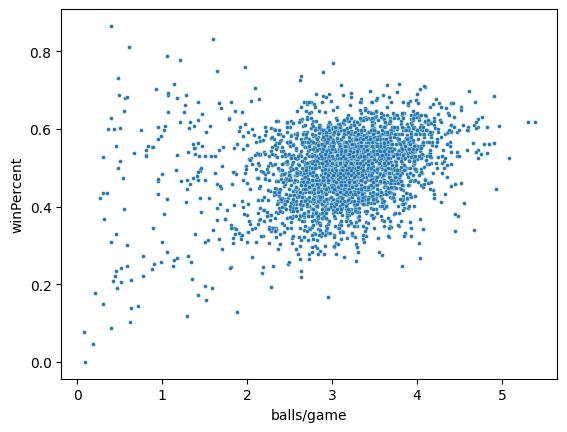

In [7]:
sns.scatterplot(x='balls/game', y='winPercent', data=walkteams, s=8)

## Max Second

In [8]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns

stealTeams = teams[['CS', 'SB', 'G', 'W', 'yearID', 'teamID']] 
stealTeams = walkteams.dropna()
stealTeams['stealAttempts'] = walkteams.SB + walkteams.CS
stealTeams['successfulStealAttemptsPercent'] = walkteams.SB/walkteams.stealAttempts

AttributeError: 'DataFrame' object has no attribute 'SB'

# Home Games versus Win Rate

Does the number of Home Games a team has in a season play a significant influence on their win rate for that season?

<Figure size 640x480 with 0 Axes>

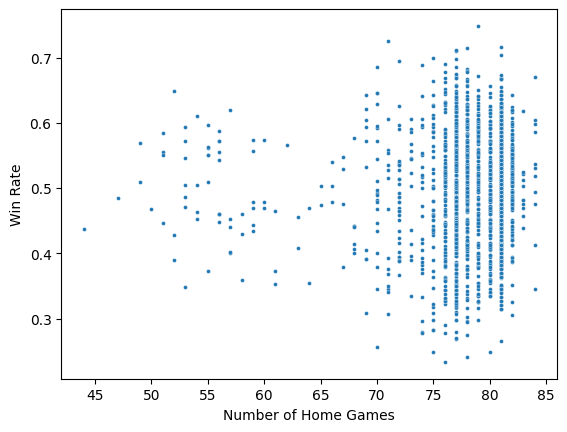

<Figure size 640x480 with 0 Axes>

In [19]:
teams = pd.read_csv('./data/core/Teams.csv')

gameData = teams[['W','L','Ghome','G']]
gameData = gameData.dropna()
# Create Win Rate Column
gameData['WR'] = gameData.W / gameData.G

plt.xlabel("Number of Home Games")
plt.ylabel("Win Rate")
sns.scatterplot(x='Ghome', y='WR', data=gameData, s=8)
plt.figure()

The figure above shows that as the number of home games a team plays increases, the win rate of that team does not increase. In other words, the number of home games a team plays in a season does not significantly impact their win rate. 

# Win Rate versus Rank

Does a higher win rate always correspond to a better rank? How effective are baseball leagues at creating brackets where the "best" team wins?

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
2627,2010,AL,BAL,BAL,E,5,162,81.0,66,96,...,141,0.982,Baltimore Orioles,Oriole Park at Camden Yards,1733018.0,101,102,BAL,BAL,BAL
2628,2010,AL,BOS,BOS,E,3,162,81.0,89,73,...,132,0.982,Boston Red Sox,Fenway Park II,3046443.0,106,105,BOS,BOS,BOS
2629,2010,AL,CHA,CHW,C,2,162,81.0,88,74,...,158,0.983,Chicago White Sox,U.S. Cellular Field,2194378.0,105,105,CHW,CHA,CHA
2632,2010,AL,CLE,CLE,C,4,162,81.0,69,93,...,179,0.982,Cleveland Indians,Jacobs Field,1394812.0,93,93,CLE,CLE,CLE
2634,2010,AL,DET,DET,C,3,162,81.0,81,81,...,171,0.982,Detroit Tigers,Comerica Park,2461237.0,101,101,DET,DET,DET
2637,2010,AL,KCA,KCR,C,5,162,81.0,67,95,...,138,0.980,Kansas City Royals,Kauffman Stadium,1615324.0,99,101,KCR,KCA,KCA
2638,2010,AL,LAA,ANA,W,3,162,81.0,80,82,...,116,0.981,Los Angeles Angels of Anaheim,Angel Stadium,3250816.0,98,98,LAA,ANA,ANA
2641,2010,AL,MIN,MIN,C,1,162,81.0,94,68,...,150,0.987,Minnesota Twins,Target Field,3223640.0,101,100,MIN,MIN,MIN
2642,2010,AL,NYA,NYY,E,2,162,81.0,95,67,...,161,0.988,New York Yankees,Yankee Stadium III,3765807.0,105,103,NYY,NYA,NYA
2644,2010,AL,OAK,OAK,W,2,162,81.0,81,81,...,147,0.984,Oakland Athletics,Oakland-Alameda County Coliseum,1418391.0,100,100,OAK,OAK,OAK


<Figure size 640x480 with 0 Axes>

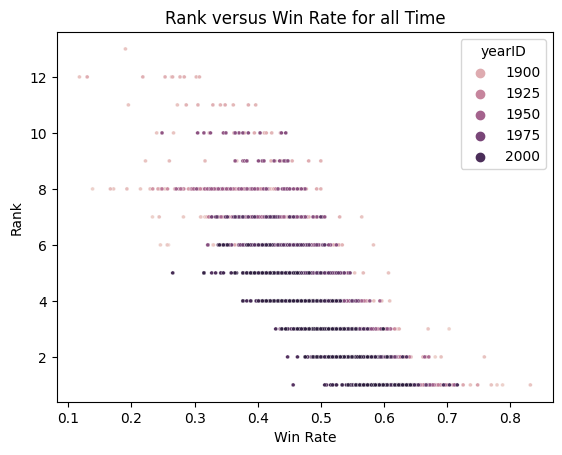

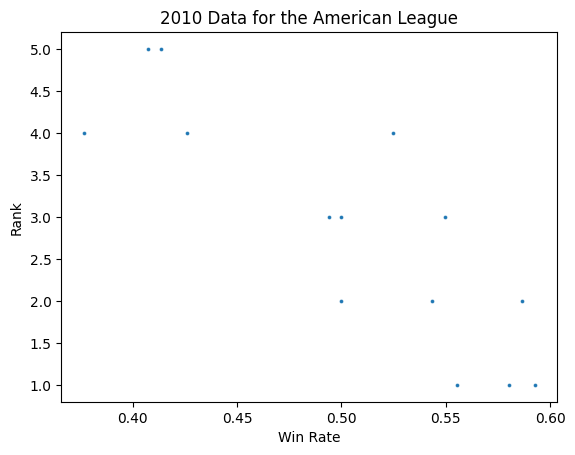

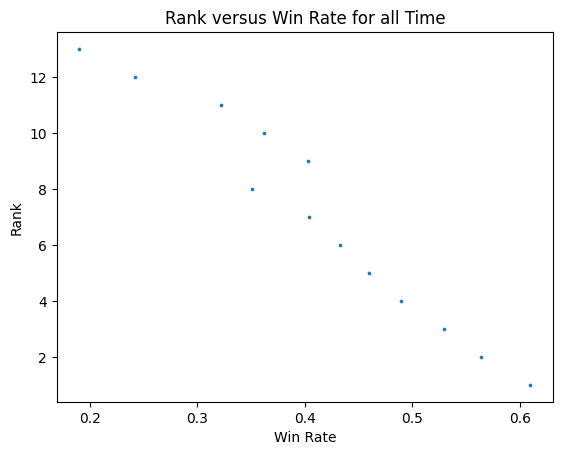

<Figure size 640x480 with 0 Axes>

In [40]:
teams = pd.read_csv('./data/core/Teams.csv')
display(teams[(teams.yearID == 2010) & (teams.lgID == 'AL')].head(10))

gameData = teams[['yearID','W','L','G','Rank','lgID']]
gameData = gameData.dropna()
# Create Win Rate Column
gameData['WR'] = gameData.W / gameData.G

twentyTenAL = gameData[(gameData.yearID == 2010) & (gameData.lgID == 'AL')]

plt.xlabel("Win Rate")
plt.ylabel("Rank")
plt.title("Rank versus Win Rate for all Time")
sns.scatterplot(x='WR', y='Rank', data=gameData, s=8, hue='yearID')
plt.figure()

plt.xlabel("Win Rate")
plt.ylabel("Rank")
plt.title("2010 Data for the American League")
sns.scatterplot(x='WR', y='Rank', data=twentyTenAL, s=8)
plt.figure()

gameData = gameData.groupby('Rank').agg({'WR': 'mean'}).reset_index()
plt.xlabel("Win Rate")
plt.ylabel("Rank")
plt.title("Rank versus Average Win Rate for all Time")
sns.scatterplot(x='WR', y='Rank', data=gameData, s=8)
plt.figure()